* Statistics of distance after every one hour between drifter and particle.

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (nc_tools,viz_tools,bathy_tools,tidetools,geo_tools)
import matplotlib.cm as cm
import scipy.io
import os
import datetime as dt

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid1 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bath = {}; lons = {};lats = {}
for grid,na in zip([grid1,grid2],['bathy2','bathy6']):
    bathy, X, Y = tidetools.get_bathy_data(grid)
    lats[na] = grid.variables['nav_lat']
    lons[na] = grid.variables['nav_lon']
    bath[na] = grid.variables['Bathymetry']

* load particle

In [3]:
drop = 'drop1/12'
runs=['oct8_10Onehour','oct8_10RFdailySmooOnehour','oct8_10reduceviscosityOnehour','oct8_101e061e05Onehour']
strings = ['Baseline', 'LongerRiver', 'LongRiver+LowerViscosity', 'LongerRiver+ReduceBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}; d = {}
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    print(path)
    f = nc.Dataset(path,'r');
    lon112[string] = f.variables['traj_lon']
    lat112[string] = f.variables['traj_lat']
    d[string] = {}

/ocean/jieliu/research/meopar/Ariane/result/oct8_10Onehour/drop1/12/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmooOnehour/drop1/12/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosityOnehour/drop1/12/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05Onehour/drop1/12/ariane_trajectories_qualitative.nc


In [4]:
drop = 'drop1/3'
runs=['oct8_10Onehour','oct8_10RFdailySmooOnehour','oct8_10reduceviscosityOnehour','oct8_101e061e05Onehour']
strings = ['Baseline', 'LongerRiver', 'LongRiver+LowerViscosity', 'LongerRiver+ReduceBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon13 = {}; lat13={};
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    print(path)
    f = nc.Dataset(path,'r');
    lon13[string] = f.variables['traj_lon']
    lat13[string] = f.variables['traj_lat']

/ocean/jieliu/research/meopar/Ariane/result/oct8_10Onehour/drop1/3/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmooOnehour/drop1/3/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosityOnehour/drop1/3/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05Onehour/drop1/3/ariane_trajectories_qualitative.nc


In [5]:
drop = 'drop2/12'
runs=['oct8_10Onehour','oct8_10RFdailySmooOnehour','oct8_10reduceviscosityOnehour','oct8_101e061e05Onehour']
strings = ['Baseline', 'LongerRiver', 'LongRiver+LowerViscosity', 'LongerRiver+ReduceBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon212 = {}; lat212={}; 
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    print(path)
    f = nc.Dataset(path,'r');
    lon212[string] = f.variables['traj_lon']
    lat212[string] = f.variables['traj_lat']

/ocean/jieliu/research/meopar/Ariane/result/oct8_10Onehour/drop2/12/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmooOnehour/drop2/12/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosityOnehour/drop2/12/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05Onehour/drop2/12/ariane_trajectories_qualitative.nc


In [6]:
drop = 'drop2/3'
runs=['oct8_10Onehour','oct8_10RFdailySmooOnehour','oct8_10reduceviscosityOnehour','oct8_101e061e05Onehour']
strings = ['Baseline', 'LongerRiver', 'LongRiver+LowerViscosity', 'LongerRiver+ReduceBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon23 = {}; lat23={};
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    print(path)
    f = nc.Dataset(path,'r');
    lon23[string] = f.variables['traj_lon']
    lat23[string] = f.variables['traj_lat']

/ocean/jieliu/research/meopar/Ariane/result/oct8_10Onehour/drop2/3/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmooOnehour/drop2/3/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosityOnehour/drop2/3/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05Onehour/drop2/3/ariane_trajectories_qualitative.nc


In [7]:
drop = 'drop3/1'
runs=['oct8_10Onehour','oct8_10RFdailySmooOnehour','oct8_10reduceviscosityOnehour','oct8_101e061e05Onehour']
strings = ['Baseline', 'LongerRiver', 'LongRiver+LowerViscosity', 'LongerRiver+ReduceBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon31 = {}; lat31={}; 
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    print(path)
    f = nc.Dataset(path,'r');
    lon31[string] = f.variables['traj_lon']
    lat31[string] = f.variables['traj_lat']

/ocean/jieliu/research/meopar/Ariane/result/oct8_10Onehour/drop3/1/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmooOnehour/drop3/1/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosityOnehour/drop3/1/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05Onehour/drop3/1/ariane_trajectories_qualitative.nc


In [8]:
drop = 'drop3/23'
runs=['oct8_10Onehour','oct8_10RFdailySmooOnehour','oct8_10reduceviscosityOnehour','oct8_101e061e05Onehour']
strings = ['Baseline', 'LongerRiver', 'LongRiver+LowerViscosity', 'LongerRiver+ReduceBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon323 = {}; lat323={};
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    print(path)
    f = nc.Dataset(path,'r');
    lon323[string] = f.variables['traj_lon']
    lat323[string] = f.variables['traj_lat']

/ocean/jieliu/research/meopar/Ariane/result/oct8_10Onehour/drop3/23/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmooOnehour/drop3/23/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosityOnehour/drop3/23/ariane_trajectories_qualitative.nc
/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05Onehour/drop3/23/ariane_trajectories_qualitative.nc


* build functions

In [9]:
namelists = ['112a','112b','13','212a','212b','23','31','323a','323b']
for string in strings:
    for name in namelists:
        d[string][name] = []

In [10]:
def calculate_distance(d,textname, strings,lon112,lat112,duration,name):
    """
    textname: e.g., 112a.txt
    strings: specify run case
    lon112: specify which run particle
    duration: if 0, then name should contain letter 'a', if not 0, then 'b'
    name: e.g., 112a, 112b and etc
    return: distance between drifter and particle after every one hour for a specific run case, like 'Baseline'
    """
    file = np.loadtxt(textname)
    for string in strings:
        if string == 'Baseline':
            na = 'bathy2'
        else:
            na = 'bathy6'
        for i in range(1, len(file)):
            distance= geo_tools.haversine(lons[na][file[i,1]-1,file[i,0]-1], lats[na][file[i,1]-1,file[i,0]-1],
                                   lon112[string][1,i-1+duration],lat112[string][1,i-1+duration])
            #print(string, name)
            d[string][name].append(distance)
    return d

In [11]:
## 
d = calculate_distance(d, '112a.txt',strings, lon112,lat112,0,'112a')
d = calculate_distance(d, '112b.txt',strings, lon112,lat112,28,'112b')
d = calculate_distance(d, '13.txt',strings, lon13,lat13,0,'13')
##
d = calculate_distance(d, '212a.txt',strings, lon212,lat212,0,'212a')
d = calculate_distance(d, '212b.txt',strings, lon212,lat212,26,'212b')
d = calculate_distance(d, '23.txt',strings, lon23,lat23,0,'23')
##
d = calculate_distance(d, '31.txt',strings, lon31,lat31,0,'31')
d = calculate_distance(d, '323a.txt',strings, lon323,lat323,0,'323a')
d = calculate_distance(d, '323b.txt',strings, lon323,lat323,23,'323b')

In [12]:
sum_number = {};mean_distance = {};stde_distance = {}
for string in strings:
    sum_number[string] = []
    mean_distance[string] = []
    stde_distance[string] = []

In [13]:
s = {}
each_item = {}
for string in strings:
    s[string] = 0
    each_item[string] = []
    for key in d[string].keys():
        sum_number[string].append(len(d[string][key])) ## sum up numbers of distances in each particle
        for distance in d[string][key]:
            s[string]+= distance
            each_item[string].append(distance)
        
    mean_distance[string] = s[string]/sum(sum_number[string])
    stde_distance[string] = np.std(each_item[string])/np.sqrt(sum(sum_number[string]))

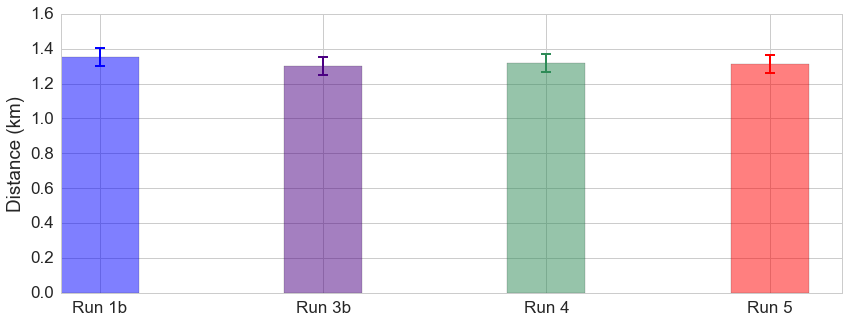

In [14]:
fig,ax = plt.subplots(1,1,figsize = (14,5))

mean_dists = [mean_distance['Baseline'],mean_distance['LongerRiver'],
              mean_distance['LongRiver+LowerViscosity'],mean_distance['LongerRiver+ReduceBoth']]
ind = np.arange(len(mean_dists))
width = 0.35

colors = ['b','Indigo','SeaGreen','r']
std_dists = [stde_distance['Baseline'],stde_distance['LongerRiver'],
             stde_distance['LongRiver+LowerViscosity'],stde_distance['LongerRiver+ReduceBoth']]
diff_dist = ax.bar(ind, mean_dists, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, mean_dists, std_dists, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Distance (km)')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(['Run 1b','Run 3b' ,'Run 4', 'Run 5'] )
plt.show()

In [15]:
#na = 'bathy6'
#file = np.loadtxt('112a.txt')
#for string in strings:
    #for i in range(1, len(file)):
        #distance= geo_tools.haversine(lons[na][file[i,1]-1,file[i,0]-1], lats[na][file[i,1]-1,file[i,0]-1],
                               #lon112[string][1,i-1],lat112[string][1,i-1])
        #d[string]['112a'].append(distance)

* Test if they are on the drifter track

In [16]:
import drifter

In [17]:
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [18]:
def Plot_every_hour_particle(tracks, startdate,day,hour, minute, lon, lat, keys,colors, t_number, i=0,flag = 'a'):
    """
    Plot the drifter track, superimposed particle track for every one hour
    """
    ind =drifter.find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    print ('Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours')
    
    bathy, X, Y = tidetools.get_SS2_bathy_data()
    [j,i]=geo_tools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,land_mask=bathy.mask)
    print(j,i,traj['time'][0].hour+0.5+traj['time'][0].minute/60)
    
    fig,ax = plt.subplots(1,1,figsize=(12,12)) 
    ax.plot(traj['lon'],traj['lat'],'ok')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    viz_tools.plot_coastline(ax, grid, coords='map')
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])  
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ## add particle track
    if flag is 'a':
        t_range = [0, t_number]
    if flag is 'b':
        t_range = [t_number,lon['Baseline'].shape[1]]
    if flag is 'None':
        t_range = [0, lon['Baseline'].shape[1]]
    for key, c in zip(keys,colors):      
        for t in range(t_range[0],t_range[-1]):
            ax.plot(lon[key][:,t],lat[key][:,t],color = c)
        ax.plot(lon[key][:,t_range[-1]-1], lat[key][:,t_range[-1]-1],color = c, label = key)
        ax.legend(loc = 'best')
            
    plt.show()

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.750277778333334 hours
429 290 16.666666666666668


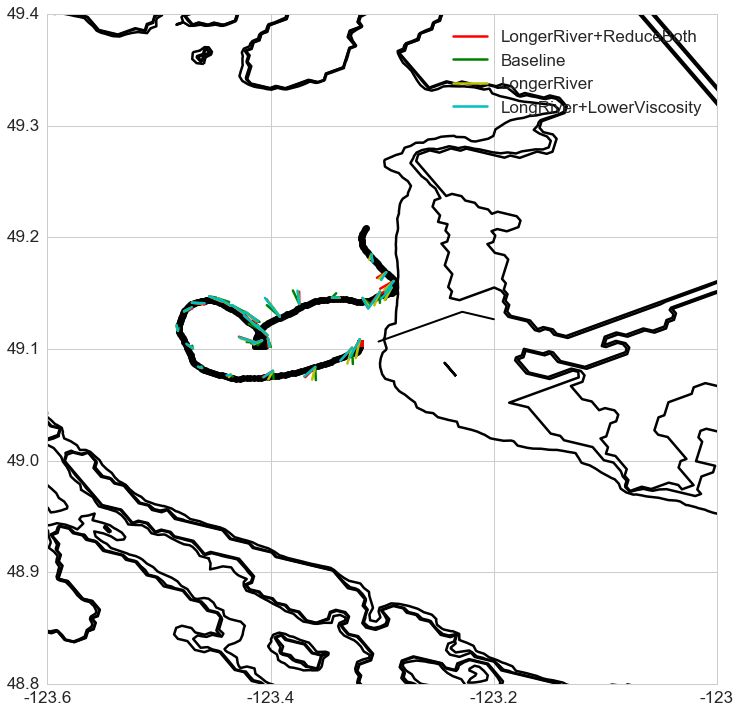

In [19]:
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
keys = ['LongerRiver+ReduceBoth','Baseline', 'LongerRiver', 'LongRiver+LowerViscosity']
colors = ['r','g','y','c']
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,16,10,lon112,lat112,keys,colors, 28,i=-1, flag = 'a')

UBC-I-0004
Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.249999998055557 hours
429 290 18.0


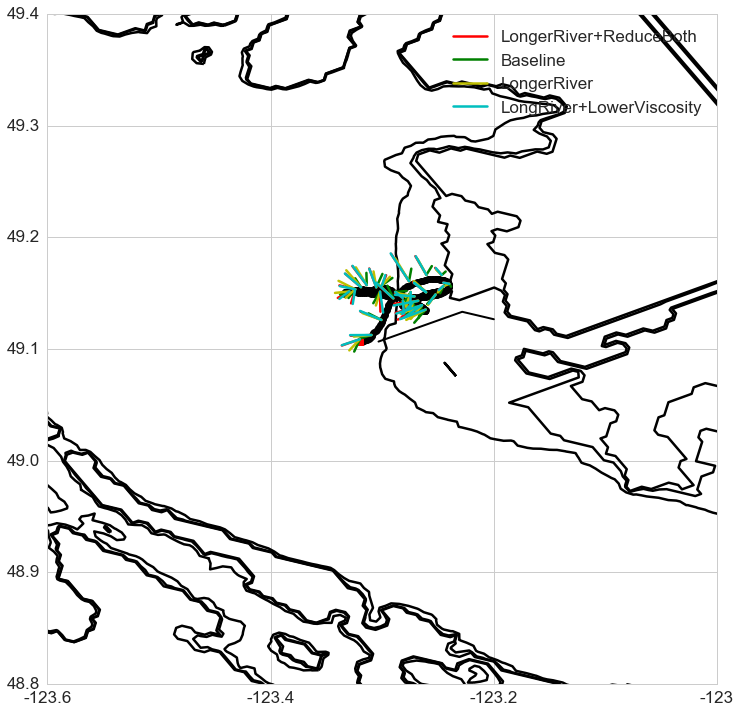

In [20]:
buoy = 3
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,17,30,lon112,lat112,keys,colors, 28,i=-1,flag ='b')

UBC-I-0010
Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.666666666111111 hours
429 290 19.833333333333332


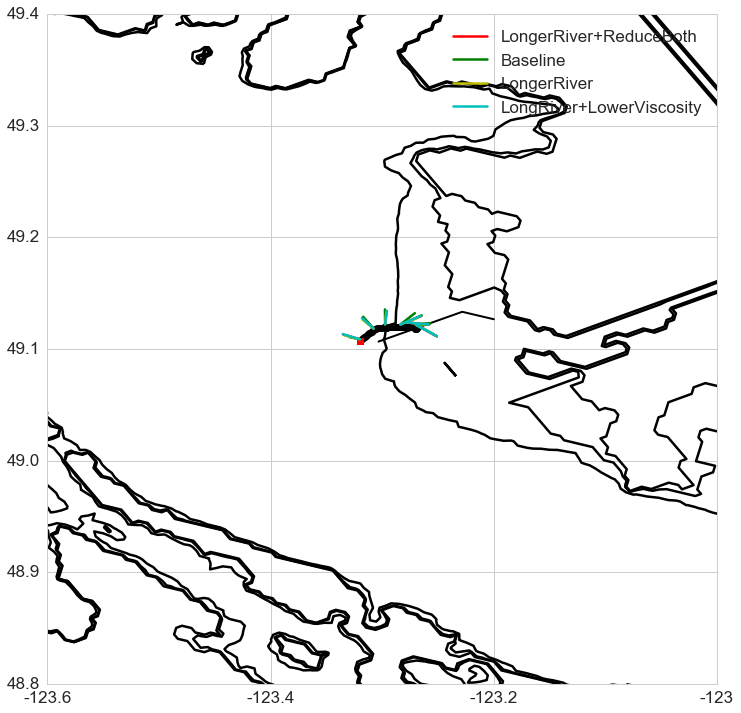

In [21]:
buoy = 9
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,19,20,lon13,lat13,keys,colors,20,i=-1,flag = 'None')

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.499722222777777 hours
427 289 16.583333333333332


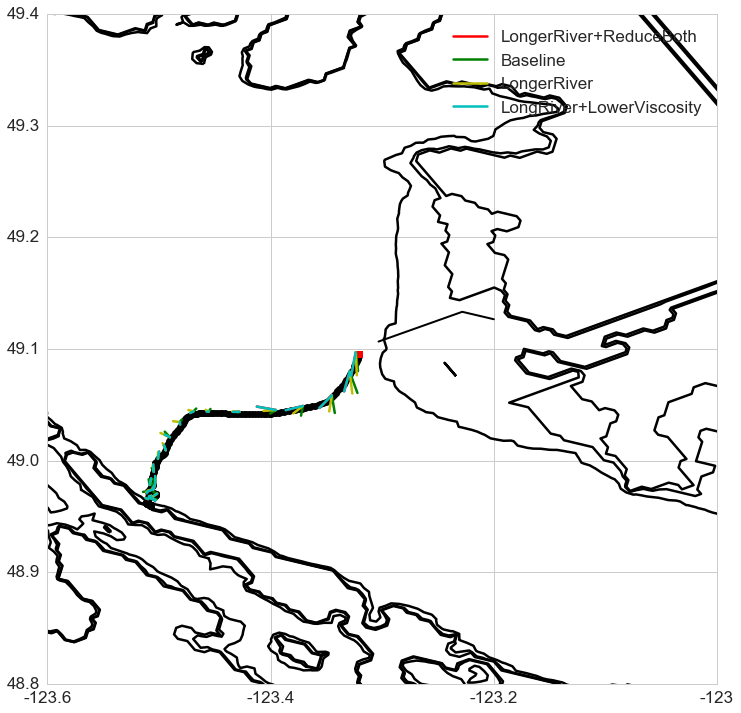

In [22]:
buoy = 1
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,16,5,lon212,lat212,keys,colors,26, i=-1,flag = 'a')

UBC-I-0005
Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
427 288 18.0


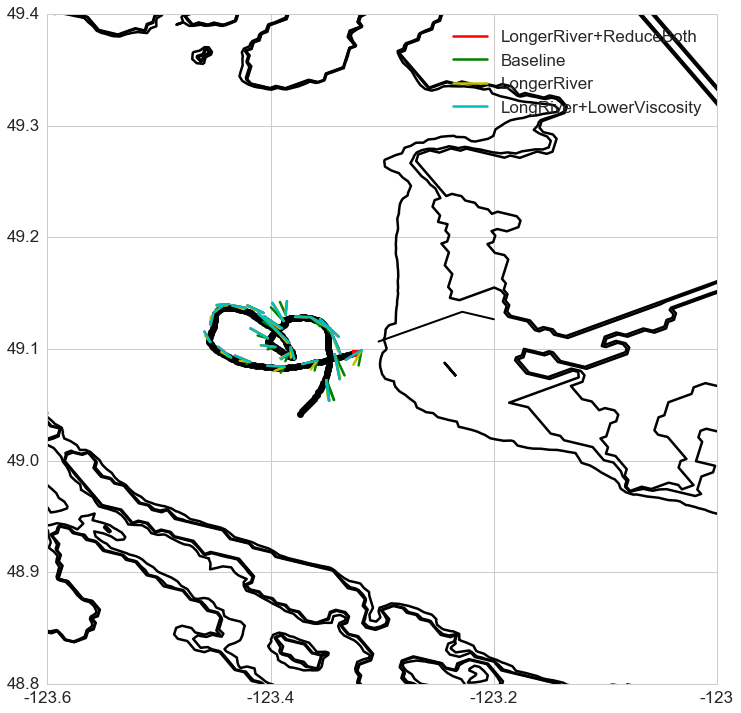

In [23]:
buoy = 4
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,17,30,lon212,lat212,keys, colors, 26,i=-1, flag ='b')

UBC-I-0008
Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.91638888888889 hours
427 287 19.833333333333332


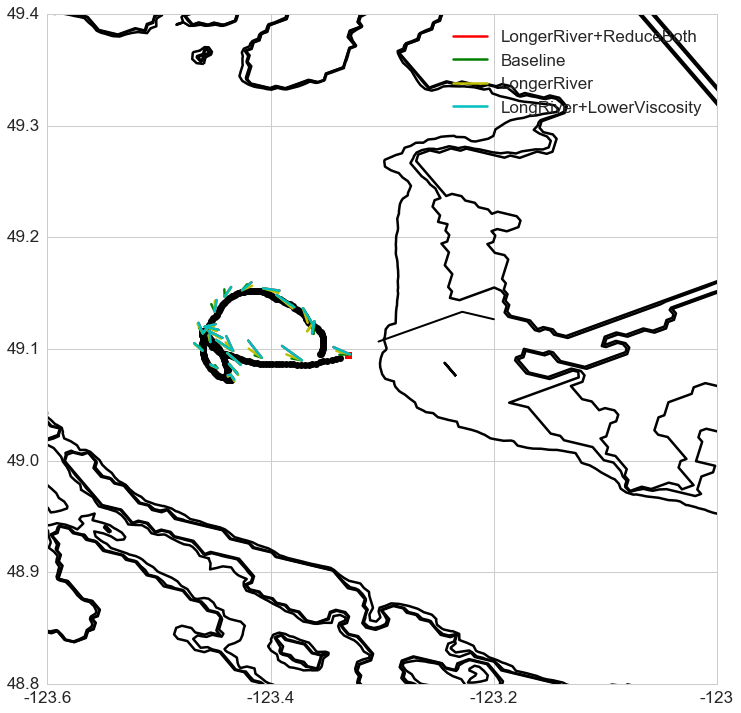

In [24]:
buoy = 7
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,19,20,lon23,lat23,keys, colors, 20,i=-1,flag = 'None')

UBC-I-0001
Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.500277778055555 hours
425 288 16.5


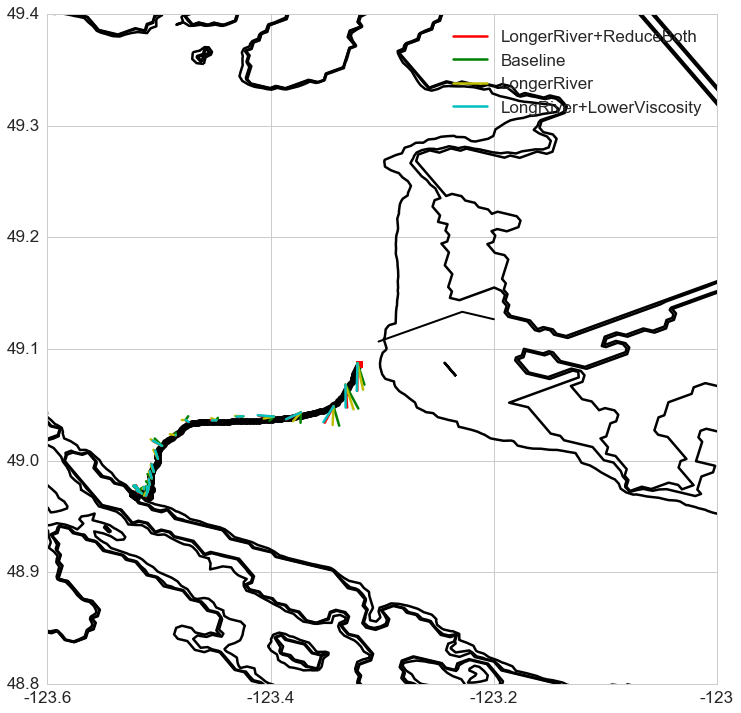

In [25]:
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,16,0,lon31,lat31, keys, colors,20,i=-1,flag = 'None')

UBC-I-0006
Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.83333333222222 hours
425 287 18.083333333333332


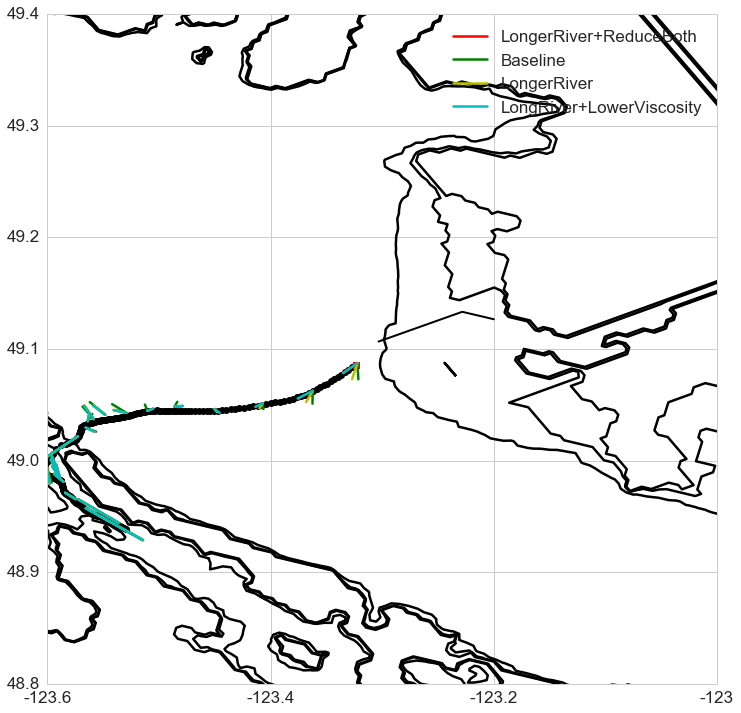

In [26]:
buoy = 5
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,17,35,lon323,lat323,keys, colors, 23,i=-1,flag ='a')

UBC-I-0007
Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.08361111111111 hours
425 287 19.666666666666668


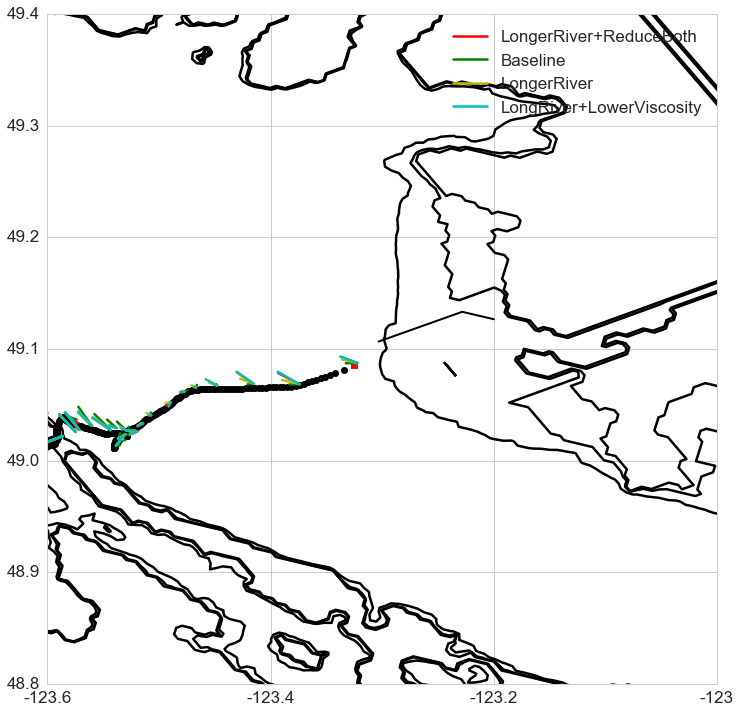

In [27]:
buoy = 6
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
Plot_every_hour_particle(tracks,dt.datetime(2014,10,8),8,19,10,lon323,lat323,keys, colors, 23,i=-1,flag= 'b')